In [39]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [40]:
X, labels = make_moons(n_samples=2000, noise=0.1, random_state=42)
X = X

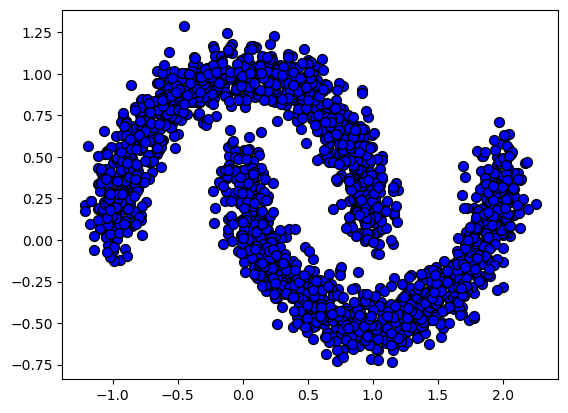

In [41]:
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='k', s=50)
plt.show()

In [42]:
data = torch.tensor(X, dtype=torch.float32).to(device)

In [43]:
class Denoiser(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(Denoiser, self).__init__()
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, t):
        t = torch.unsqueeze(t, 1)
        x_for = torch.cat((x, t), dim=1)
        x_for = torch.relu(self.fc1(x_for))
        x_for = torch.relu(self.fc2(x_for))
        x_for = torch.relu(self.fc3(x_for))
        x_for = torch.relu(self.fc4(x_for))
        return self.fc5(x_for)

model = Denoiser(2, 2, 128).to(device)

In [44]:
class DDPM:
    def __init__(self, model, timesteps=1000, beta_start=0.0001, beta_end=0.02):
        self.model = model
        self.timesteps = timesteps
        self.reversed_time_steps = np.arange(self.timesteps)[::-1]
        self.betas = torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32, device=device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        #self.alphas = self.alphas[20:]
        #self.betas = self.betas[20:]
        #self.alphas_cumprod = self.alphas_cumprod[20:]

    def sample_sde(self, num_samples):
        with torch.no_grad():  # avoid backprop wrt model parameters
            x = torch.randn((num_samples, 2), dtype=torch.float32, device=device)
            for i, t in enumerate(self.reversed_time_steps):
                
                
                #TODO
                t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)
                eps = self.model(x, t_tensor)

                alpha_t = self.alphas[t]
                alpha_t_cumprod = self.alphas_cumprod[t]
                beta_t = self.betas[t]

                mean = 1/(torch.sqrt(alpha_t))*(x-(beta_t/torch.sqrt(1-alpha_t_cumprod))*eps)

                noise = torch.randn_like(x)
                x = mean + torch.sqrt(beta_t) * noise
        return x

    def sample_ode(self, num_samples):
        with torch.no_grad(): # avoid backprop wrt model parameters
            x = torch.randn((num_samples, 2), dtype=torch.float32, device=device)
            for i, t in enumerate(self.reversed_time_steps):
                
                #TODO
                t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)
                
                eps = self.model(x, t_tensor)
                score = -eps/torch.sqrt(1.0 - self.alphas_cumprod[t])

                alpha_t = self.alphas[t]
                alpha_t_cumprod = self.alphas_cumprod[t]
                beta_t = self.betas[t]
                xip = (2-torch.sqrt(1-beta_t))*x+1/2*beta_t*score
                x = xip# + torch.sqrt(beta_t)*noise
        return x
    
    def ode_score(self, x, t, ns):
        with torch.no_grad():
            eps = self.model(x, t)  # Shape: (batch_size, feature_dim)
            alpha_terms = torch.sqrt(1.0 - self.alphas_cumprod[ns].to(x.device))  # Ensure correct device
            score = -eps / alpha_terms.view(-1, 1)  # Reshape to match eps
        return score

    def load(self, path):
        """Load the model's state from a file."""
        self.model.load_state_dict(torch.load(path, map_location=next(model.parameters()).device))

    def store(self, path):
        """Store the model's state to a file."""
        torch.save(self.model.state_dict(), path)

    def train(self, data, epochs=1000, batch_size=64, lr=1e-3):
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        
        losses = []
        mean_loss = 0
        i = 0

        for epoch in range(epochs):
            
            for batch in dataloader:
                optimizer.zero_grad()
                t = torch.randint(0, self.timesteps, (batch.size(0),), device=batch.device).long()
                noise = torch.randn_like(batch, dtype=torch.float32)
                noisy_data = torch.sqrt(self.alphas_cumprod[t]).view(-1, 1) * batch + torch.sqrt(1.0 - self.alphas_cumprod[t]).view(-1, 1) * noise
                predicted_noise = self.model(noisy_data, t)
                loss = criterion(predicted_noise, noise)
                mean_loss+=loss.item()
                i+=1
                loss.backward()
                optimizer.step()

            if epoch % 100 == 0:
                losses.append(mean_loss/i)
                print(f'Epoch {epoch}, Loss: {mean_loss/i}')
                mean_loss = 0
                i = 0
        return losses
    
ddpm = DDPM(model, timesteps=80)

In [45]:
ddpm.load("models/simplemoons")

In [46]:
new_samples = ddpm.sample_ode(num_samples=5000).cpu().detach().numpy()

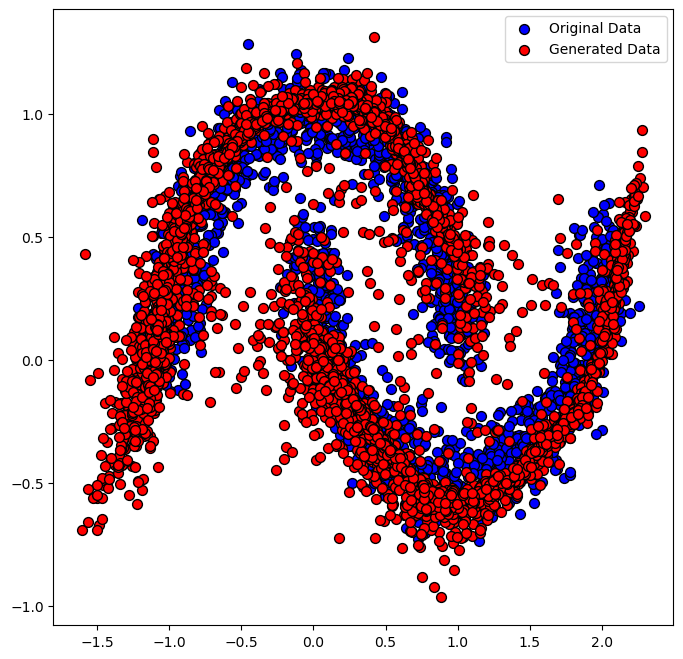

In [47]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='k', s=50, label='Original Data')
plt.scatter(new_samples[:, 0], new_samples[:, 1], c='red', marker='o', edgecolor='k', s=50, label='Generated Data')
plt.legend()
plt.show()

In [48]:
class MLPStudent(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)  # +1 for time conditioning
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, t):
        t = t.view(-1, 1)  # Ensure time is a column vector
        xt = torch.cat([x, t], dim=1)  # Concatenate x and t
        h = F.silu(self.fc1(xt))
        h = F.silu(self.fc2(h))
        h = F.silu(self.fc3(h))
        h = F.silu(self.fc4(h))
        return self.fc5(h)  # Predicts an update for x

In [ ]:
class ConsistencyModel:
    def __init__(self, student_model, teacher_model, timesteps=80, learning_rate=1e-3, mu=0.95):
        self.student_model = student_model  # Consistency model
        self.teacher_model = teacher_model  # Pretrained DDPM model
        self.timesteps = timesteps
        self.learning_rate = learning_rate
        self.mu = mu  # EMA parameter
        self.optimizer = optim.Adam(self.student_model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()
        
        self.theta_minus_model = self.create_ema_model()
        
    def karras_schedule(self, i, T=80.0, epsilon=2e-3, rho=7):
        N = self.timesteps
        t_i = (epsilon**(1/rho) + (i - 1) / (N - 1) * (T**(1/rho) - epsilon**(1/rho)))**rho
        return t_i
    
    def create_ema_model(self):
        """ Create a copy of the student model for EMA tracking """
        ema_model = type(self.student_model)()  # Instantiate the same model type
        ema_model.load_state_dict(self.student_model.state_dict())  # Copy parameters
        for param in ema_model.parameters():
            param.requires_grad = False  # Freeze EMA model
        return ema_model.to(device)
    
    def update_ema(self):
        """ Exponential Moving Average (EMA) update for θ⁻ """
        with torch.no_grad():
            for param, param_ema in zip(self.student_model.parameters(), self.theta_minus_model.parameters()):
                param_ema.data = self.mu * param_ema.data + (1 - self.mu) * param.data

    def train(self, dataset, epochs=1000, batch_size=64):
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        for epoch in range(epochs):
            epoch_loss = 0
            for x in dataloader:
                self.optimizer.zero_grad()
                
                # Sample t_n and t_{n+1}
                n = torch.randint(1, self.timesteps - 1, (x.size(0),), device=x.device)
                t_n = self.karras_schedule(n)    # Select t_n
                
                t_np1 = self.karras_schedule(n+1)  # Select t_n+1
                
                # Sample x_{t_{n+1}}
                noise = torch.randn_like(x, device=x.device)
                
                x_tnp1 = x + t_np1.view(-1,1) * noise
                
                # Compute teacher output (ODE solver)
                with torch.no_grad():
                    phi_tn = self.teacher_model.ode_score(x_tnp1, t_np1, n)
                    x_hat_phi_tn = x_tnp1 - t_np1.view(-1, 1) * (t_n.view(-1, 1) - t_np1.view(-1, 1)) * phi_tn
                
                # Compute student output
                student_output = self.student_model(x_tnp1, t_np1)
                
                with torch.no_grad():  # Stop gradient flow
                    theta_minus_output = self.theta_minus_model(x_hat_phi_tn, t_n)
                
                # Compute loss
                loss = self.loss_fn(student_output, phi_tn)
                loss.backward()
                self.optimizer.step()
                
                # EMA update
                self.update_ema()
                
                epoch_loss += loss.item()
            
            if epoch%100==0:
                print(f"Epoch {epoch}, Loss: {epoch_loss / len(dataloader)}")
        
        return self.student_model

In [50]:
student_model = MLPStudent().to(device)
consistency_model = ConsistencyModel(student_model, ddpm)

student_model = consistency_model.train(data, epochs=1000, batch_size=128)

Epoch 0, Loss: 1362.1774559020996


Epoch 100, Loss: 3.171712674200535
Epoch 200, Loss: 3.4714910835027695
Epoch 300, Loss: 4.257800787687302
Epoch 400, Loss: 1.2096815090626478
Epoch 500, Loss: 1.188454508781433
Epoch 600, Loss: 0.9738341830670834
Epoch 700, Loss: 1.0725682601332664
Epoch 800, Loss: 0.8714103661477566
Epoch 900, Loss: 1.1895809806883335


In [51]:
def sample_consistency_model(model, num_samples=1000):
    x = torch.randn((num_samples, 2), device=device)  # Initialize with noise
    t = torch.zeros(num_samples, device=device)  # Use t=0 for final samples
    with torch.no_grad():
        x = model(x, t)
    return x

samples = sample_consistency_model(student_model, num_samples=1000).cpu().detach().numpy()

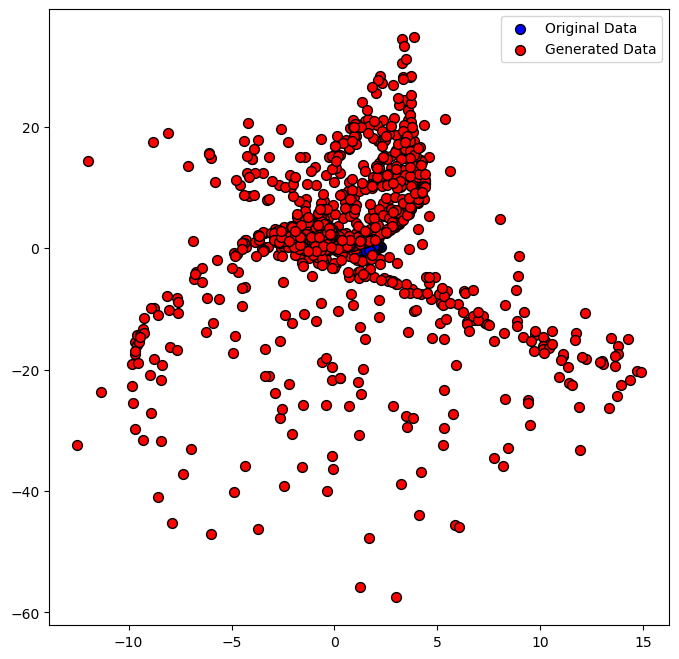

In [52]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='k', s=50, label='Original Data')
plt.scatter(samples[:, 0], samples[:, 1], c='red', marker='o', edgecolor='k', s=50, label='Generated Data')
plt.legend()
plt.show()